# Deteccão de COVID-19 em imagens de raio-X

O objetivo deste exercício é treinar e avaliar um classificador capaz de detectar a presença de COVID-19 em imagens de raio-X.

As métricas a serem reportadas são F1 e Equal Error Rate (ERR) e seu respectivo threshold.

Note que uma das dificuldades deste exercicio será processar as imagens, que tem 1100 x 1100 pixels.

Dica: Utilize o [pyeer](https://pypi.org/project/pyeer/) para plotar o EER.

Nome: **Orlem Lima dos Santos**

# Embemble Learning


A solution to the high variance of neural networks is to train multiple models and combine their predictions.

The idea is to combine the predictions from multiple good but different models.

A good model has skill, meaning that its predictions are better than random chance. Importantly, the models must be good in different ways; they must make different prediction errors.

Combining the predictions from multiple neural networks adds a bias that in turn counters the variance of a single trained neural network model. The results are predictions that are less sensitive to the specifics of the training data, choice of training scheme, and the serendipity of a single training run.

In addition to reducing the variance in the prediction, the ensemble can also result in better predictions than any single best model

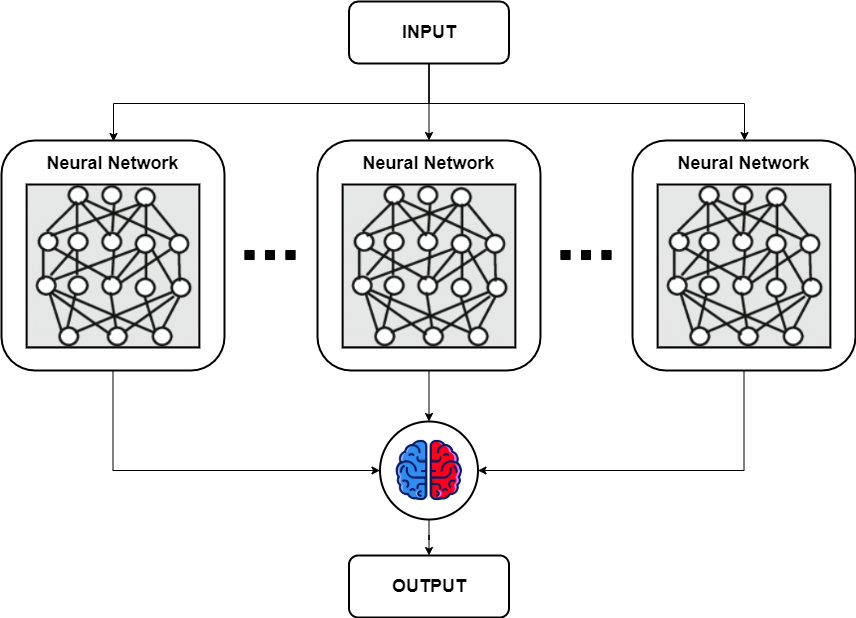

# Inicialização dos parâmetros

In [ ]:
version = "effnetB0_covid19_finetune_imagenet_ensemble_test5" #@param {type: "string"}
backbones = 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b3', 'efficientnet-b4','efficientnet-b5'#@param {type: "raw"}
lr = 1e-2#@param {type: "number"}
lr_final = 1e-100#@param {type: "number"}
lr_epoch = 50#@param {type: "integer"}
w_decay = 0#@param {type: "number"}
bs = 128#@param {type: "integer"}
accum_grads = 5#@param {type: "integer"}
patience = 20#@param {type: "integer"}
max_epochs = 100#@param {type: "integer"}
drop_rate_fc = 0.3#@param {type: "number"}
drop_rate_effnet = 0.5#@param {type: "number"}
drop_connect_rate_effnet = 0.5#@param {type: "number"}
freeze_BN = False#@param {type: "boolean"}
freeze = False#@param {type: "boolean"}

# Define hyperparameters
hparams = {"version": version,
          'backbones':backbones,
          "lr": lr,
          "lr_final": lr_final,
           "lr_epoch": lr_epoch,
          "w_decay": w_decay,
          "bs": bs,
          "drop_rate_fc": drop_rate_fc,
          "drop_rate_effnet": drop_rate_effnet,
          "drop_connect_rate_effnet": drop_connect_rate_effnet,
          "patience": patience,
          "accum_grads": accum_grads,
          "max_epochs": max_epochs,
          "freeze_BN": freeze_BN,
          "freeze": freeze,}
hparams

{'accum_grads': 5,
 'backbones': ('efficientnet-b0',
  'efficientnet-b1',
  'efficientnet-b3',
  'efficientnet-b4',
  'efficientnet-b5'),
 'bs': 128,
 'drop_connect_rate_effnet': 0.5,
 'drop_rate_effnet': 0.5,
 'drop_rate_fc': 0.3,
 'freeze': False,
 'freeze_BN': False,
 'lr': 0.01,
 'lr_epoch': 50,
 'lr_final': 1e-100,
 'max_epochs': 100,
 'patience': 20,
 'version': 'effnetB0_covid19_finetune_imagenet_ensemble_test5',
 'w_decay': 0}

## Inicializando o Neptune

In [ ]:
# !pip install neptune-client
# !pip install pytorch_lightning==1.2.10
# !pip install efficientnet_pytorch
# !pip install pyeer

In [ ]:
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [ ]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMmJkZTg1Yy1kMjQ1LTRmMjEtYjBmYy1kMjVlMmMxODcyMTgifQ==",
    project_name='orllem/Aula7Covid')

NeptuneLogger will work in online mode


## Importação das bibliotecas

In [ ]:
from collections import OrderedDict
import h5py
import numpy as np
import gc
import os
import matplotlib.pyplot as plt
from random import sample
from collections import Counter

import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from google.colab import drive

import torchvision
from torchvision import transforms

import pytorch_lightning as pl
import torchmetrics
from torchmetrics import F1
from torchmetrics.functional import accuracy

from efficientnet_pytorch import EfficientNet
import nvidia_smi

# pytorch_lightning.utilities.seed.seed_everything(seed=123)

In [ ]:
f1 = F1(num_classes=2, average='weighted', compute_on_step=True)

In [ ]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

Pytorch Lightning Version: 1.2.10
Device name: b'Tesla P100-PCIE-16GB'


In [ ]:
def show_batch(dataset):
    """ Show a batch of 6 random images from a dataset.

    """
    fig = plt.figure(1, figsize=(15, 7))
    samples = np.random.randint(0, high=len(dataset), size=9)

    for i, sample in enumerate(samples):
        image, label = dataset[sample]
        image = (image + 1)/2 # reverse advprop transform 
        ax = fig.add_subplot(3, 3, i+1)
        if isinstance(image, np.ndarray):
          ax.imshow(image)
        else:
          ax.imshow(image.permute(2,1,0).numpy())

        ax.set_title(label)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 

## Dataset e dataloader

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### Carregamento, criação dataset e do dataloader

In [ ]:
# download_save flag must be seted to True to download and save to folders
download_save = not all([os.path.isdir('test'), os.path.isdir('test2')]) 

In [ ]:
if download_save:
  # O download demora.
  !gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/* .
  !gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test2.hdf5 .

Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/valid.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/test2.hdf5...
Copying gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/train.hdf5...
/ [4/4 files][ 12.4 GiB/ 12.4 GiB] 100% Done  66.8 MiB/s ETA 00:00:00           
Operation completed over 4 objects/12.4 GiB.                                     
Skipping existing item: file://./test2.hdf5


## Create folders with the train, valid  and test datasets 

**for each image of the hdf5 file it is created a hdf5 file in the folders**

In [ ]:
if download_save:
  
  # only pre-processed test and test2
  paths = ['test', 'test2']

  for path in paths:
    !mkdir $path 

    path_dir = './' + path +'.hdf5'
    h5file = h5py.File(path_dir, 'r')
    filename = path + '.hdf5'
    !rm $filename
    images = h5file['data'][:]
    labels = h5file['label'][:]
    
    del path_dir
    del filename
    del h5file
    
    np.save(path+'_labels.npy', labels)
    for i in range(len(images)):
      np.save(path + '/' + str(i) + '.npy', images[i]) 
    
    del labels
    del images

  gc.collect()  

Aqui criamos um dataset sem aumento de dados

In [ ]:
size_large = (256, 256)
size_final = (224, 224)

transform_train = transforms.Compose([                                  
    transforms.ToPILImage(),
    transforms.Resize(size=size_final),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda img: img*2.0 - 1.0)])

transform_valid = transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=size_final),
    torchvision.transforms.Lambda(lambda img: img*2.0 - 1.0)])

In [ ]:
class Hdf5_Dataset(torch.utils.data.Dataset):

  def __init__(self, path, transform, balance=False):
    self.images = os.listdir(path)
    self.images = sorted(self.images, key = lambda x: int(x[:-4])) # sort values of the folder
    self.images = [path+'/'+s for s in self.images]
    self.labels = np.load(path + '_labels.npy').tolist()
    self.transform = transform
    
    """
    Increase number of covid samples of training set to balance the training dataset 
    
    The idea here is simple, it gets enough random covid cases to match the number of normal cases
    """
    if (path=='train' or path=='valid') and balance==True:
      counter = Counter(self.labels)
      dif = counter[0] - counter[1]
      
      zero_index = [i for i,x in enumerate(self.labels) if x == 1]
      
      comp_images = sample(zero_index, dif)
      self.images = self.images + [self.images[i] for i in comp_images]
      self.labels = self.labels + [self.labels[i] for i in comp_images]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = self.labels[idx]

    img = np.load(self.images[idx])
    img = ((img/np.max(img))*255).astype(np.uint8)

    img = self.transform(img).tile(3, 1, 1).detach().float()
  
    return img, label

In [ ]:
test_dataset_old = Hdf5_Dataset('test', transform=transform_valid)

test_dataset = Hdf5_Dataset('test2', transform=transform_valid)

In [ ]:
print('Número de amostras de teste:', len(test_dataset_old))

print('Número de amostras de teste:', len(test_dataset))

Número de amostras de teste: 1000
Número de amostras de teste: 1000


In [ ]:
test_labels = test_dataset_old.labels
print(Counter(test_labels))

test_labels = test_dataset.labels
print(Counter(test_labels))

Counter({0: 558, 1: 442})
Counter({0: 909, 1: 91})


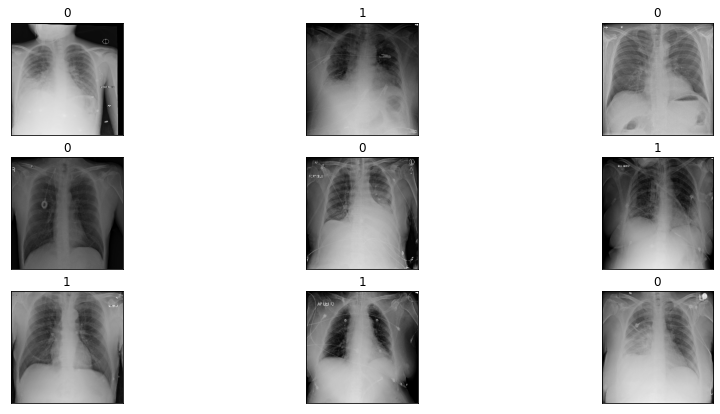

In [ ]:
show_batch(test_dataset_old)

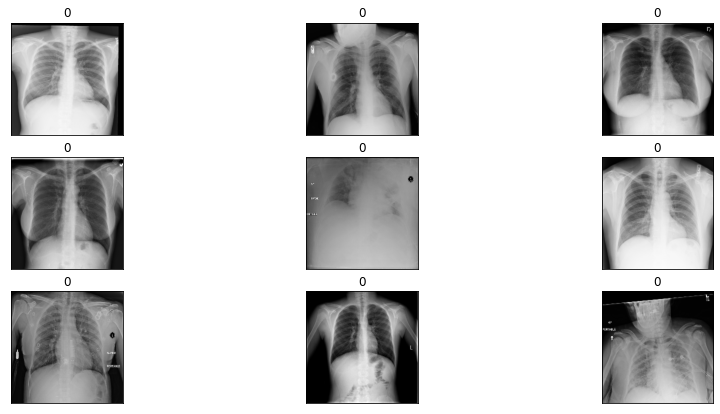

In [ ]:
show_batch(test_dataset)

In [ ]:
batch_size = hparams['bs']


test_dataloader_old = DataLoader(test_dataset_old, batch_size=batch_size, shuffle=False,  num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,  num_workers=4)

print('Número de minibatches de teste:', len(test_dataloader_old))
print('Número de minibatches de teste 2:', len(test_dataloader))

x_test, y_test = next(iter(test_dataloader))
print("\nDimensões dos dados de um minibatch:", x_test.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_test), torch.max(x_test))
print("Tipo dos dados das imagens:         ", type(x_test))
print("Tipo das classes das imagens:       ", type(y_test))

Número de minibatches de teste: 8
Número de minibatches de teste 2: 8

Dimensões dos dados de um minibatch: torch.Size([128, 3, 224, 224])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


# Definindo o Modelo

In [ ]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        print('freezing ', m)
        m.eval()

## Criação do modelo Pytorch Lightning

## Etapas do modelo

**O modelo tem duas etapas:** 

1. No treino a predição é obtida pela média (**soft-majority vote**) das predições do 5 modelos. 

2. Na validação e teste é feito um **hard-majority vote** onde se pelos 3 predições (onde temos aqui 5 modelos) forem de covid (1) é classe predita é de COVID. 




In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, logprobs, target, smoothing=0.1):
        confidence = 1. - smoothing
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

In [ ]:
criterion = LabelSmoothingCrossEntropy()

In [ ]:
class ModelEffnet(nn.Module):
    def __init__(self, backbone):
        super(ModelEffnet, self).__init__()

        override_params = {'dropout_rate':hparams['drop_rate_effnet'],
                           'drop_connect_rate':hparams['drop_connect_rate_effnet']}
        
        self.feature_extraction = EfficientNet.from_pretrained(backbone, advprop=True, **override_params)

        # freeze BN
        if hparams['freeze_BN']:
          self.feature_extraction = self.feature_extraction.apply(set_bn_eval)

        if hparams['freeze']:
          print('freezing effnet')
          for param in self.feature_extraction.parameters():
            param.requires_grad = False

        self._avg_pooling = nn.AdaptiveAvgPool2d(1)
        self._dropout = nn.Dropout(hparams['drop_rate_fc'])
        
        if backbone=='efficientnet-b7': 
          self._fc = nn.Linear(2560, 2)
        elif backbone=='efficientnet-b5': 
          self._fc = nn.Linear(2048, 2)  
        elif backbone=='efficientnet-b4': 
          self._fc = nn.Linear(1792, 2)   
        elif backbone=='efficientnet-b3':
          self._fc = nn.Linear(1536, 2)  
        elif backbone=='efficientnet-b2':
          self._fc = nn.Linear(1408, 2) 
        else:
          self._fc = nn.Linear(1280, 2) 
    
    def forward(self, x):
      features = self.feature_extraction.extract_features(x)
      pool = self._avg_pooling(features)
      
      x = pool.flatten(start_dim=1)
      # print('x', x.shape)
      x = self._dropout(x)
      logits = self._fc(x)    
      return logits

In [ ]:
class EffnetClassifier(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.hparams = hparams
        
        self._blocks = nn.ModuleList([])

        for backbone in hparams['backbones']:
          self._blocks.append(ModelEffnet(backbone))
        

    def forward(self, x):
        
        pred_res = []
        for block in self._blocks:
          logits = block(x)
          softmaxs = F.softmax(logits, dim=1)
          pred_res.append(softmaxs)    

        pred_res = torch.stack(pred_res)
        return pred_res  # softmax

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
  
        # predict 
        softs = self(x) 
        
        # mean value of predictions - followed by log
        softs = torch.mean(softs, dim=0)
        log_softs = torch.log(softs)

        # loss cross-entropy compute
        cross_loss = criterion(log_softs, y)

        self.log('cross_loss_step', cross_loss, prog_bar=True)
        
        return cross_loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()       

        self.log("train_loss", loss, prog_bar=True)
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        # predict 
        softs = self(x)
        softs_mean = torch.mean(softs, dim=0)
        log_softs = torch.log(softs_mean)

        val_cross_loss = F.nll_loss(log_softs, y)

        pred_softs = torch.stack([torch.argmax(torch.exp(k), dim=1) for k in softs])
        
        
        # if at least 3 classifiers are predicted as covid set the prediction as covid
        preds = torch.zeros(len(y)).cuda()
        counts_preds = torch.count_nonzero(pred_softs, dim=0)
        preds[counts_preds>=3] = 1
        preds = preds.type(torch.cuda.ByteTensor)
        y = y.type(torch.cuda.ByteTensor)

        val_f1 = f1(preds, y, num_classes=2, average='weighted')
        val_acc = accuracy(preds, y)

        val_f1 = torch.nan_to_num(val_f1, nan=1)

        self.log('val_loss_step', val_cross_loss, prog_bar=True)
        self.log('val_acc_step', val_acc, prog_bar=True)
        self.log('val_f1_step', val_f1, prog_bar=True)

        return {"val_loss_step": val_cross_loss, "val_acc_step": val_acc,  
                "val_f1_step": val_f1}

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x['val_loss_step'] for x in outputs]).mean()
        val_acc = torch.stack([x['val_acc_step'] for x in outputs]).mean()
        val_f1 = torch.stack([x['val_f1_step'] for x in outputs]).mean()

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        self.log("val_f1", val_f1, prog_bar=True)
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        
        # predict 
        softs = self(x)
        softs_mean = torch.mean(softs, dim=0)
        log_softs = torch.log(softs_mean)

        cross_loss = F.nll_loss(log_softs, y)
        
        # predict hard-majority vote
        # if at least 3 classifiers are predicted as covid set the prediction as covid
        pred_softs = torch.stack([torch.argmax(torch.exp(k), dim=1) for k in softs])
        preds = torch.zeros(len(y))
        counts_preds = torch.count_nonzero(pred_softs, dim=0)
        preds[counts_preds>=3] = 1
        
        preds = preds.type(torch.ByteTensor)
        # y = y.cuda()

        y = y.cpu().type(torch.ByteTensor)

        # print(preds.shape)
        # print(y.shape)
        
        # print(softs_mean)
        # print(preds)
        # print(y)
        
        acc = accuracy(preds, y)
        f1_test = f1(softs_mean.cpu(), y)

        # print('f1', f1_test)
        # print('--------')
        # handle bug in the f1score when all values are 0 
        # f1_test = torch.nan_to_num(f1_test, nan=1)
        
        return {"test_loss_step": cross_loss, "test_acc_step": acc, 
                "test_f1_step": f1_test}

    def test_epoch_end(self, outputs):
        loss = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        acc = torch.stack([x['test_acc_step'] for x in outputs]).mean()
        f1 = torch.stack([x['test_f1_step'] for x in outputs]).mean()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams["lr"],
            nesterov=True,
            momentum=0.9,
            weight_decay=self.hparams["w_decay"],
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max = self.hparams["lr_epoch"], 
                eta_min=self.hparams["lr_final"]  # total epochs to run
            )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_f1'}
    
    def train_dataloader(self):
      return train_dataloader    

## Instância do modelo

In [ ]:
pl_model = EffnetClassifier(hparams=hparams)

trainer = pl.Trainer(gpus=1)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth



Loaded pretrained weights for efficientnet-b0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b1-0f3ce85a.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b1-0f3ce85a.pth



Loaded pretrained weights for efficientnet-b1


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b3-cdd7c0f4.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b3-cdd7c0f4.pth



Loaded pretrained weights for efficientnet-b3


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b4-44fb3a87.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b4-44fb3a87.pth



Loaded pretrained weights for efficientnet-b4


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b5-86493f6b.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b5-86493f6b.pth



Loaded pretrained weights for efficientnet-b5


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


## Teste

In [ ]:
best_model = '/content/drive/MyDrive/aula7_checkpoints_AP/effnetB0_covid19_finetune_imagenet_ensemble_test5-epoch=27-val_f1=0.96.ckpt'
print(best_model)
test_model = EffnetClassifier.load_from_checkpoint(best_model, hparams=hparams).cuda().eval()

/content/drive/MyDrive/aula7_checkpoints_AP/effnetB0_covid19_finetune_imagenet_ensemble_test5-epoch=27-val_f1=0.96.ckpt
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b1
Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b5


In [ ]:
trainer.test(test_model, test_dataloader_old)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9535006284713745,
 'test_f1': 0.956177294254303,
 'test_loss': 0.1593714952468872}
--------------------------------------------------------------------------------


[{'test_acc': 0.9535006284713745,
  'test_f1': 0.956177294254303,
  'test_loss': 0.1593714952468872}]

In [ ]:
trainer.test(test_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9559044241905212,
 'test_f1': 0.9675441384315491,
 'test_loss': 0.1865096092224121}
--------------------------------------------------------------------------------


[{'test_acc': 0.9559044241905212,
  'test_f1': 0.9675441384315491,
  'test_loss': 0.1865096092224121}]

In [ ]:
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from sklearn import metrics

In [ ]:
# predict hard-majority vote
def pred_emsemble(softs):
  pred_softs = torch.stack([torch.argmax(k, dim=1) for k in softs])
  preds = torch.zeros(len(y)).cuda()
  counts_preds = torch.count_nonzero(pred_softs, dim=0)
  preds[counts_preds>=3] = 1

  return preds.type(torch.cuda.ByteTensor)

###  Dataset da aula passada

In [ ]:
y_true = list()
y_pred = list()
y_pred_proba = list()
test_model.eval()

with torch.no_grad():
  for batch in test_dataloader_old:
    inputs, y = batch
    softs = test_model(inputs.cuda())
    softs_mean = torch.mean(softs, dim=0)
    # print(softs_mean)
    pred = pred_emsemble(softs)    
    
    y_true.append(y.cpu().numpy())
    y_pred.append(pred.cpu().numpy())
    y_pred_proba.append(softs_mean.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_pred_proba = np.concatenate(y_pred_proba)

In [ ]:
# given the average predict probability we compute the the class using the threshold=0.5 
y_proba_covid = y_pred_proba[:,1] # probability of covid-19
y_pred_class = np.zeros(len(y_proba_covid))
y_pred_class[y_proba_covid >= 0.5] = 1
y_pred_class[y_proba_covid < 0.5] = 0

In [ ]:
# f1 score (hard-majority vote)
print('f1 - hard-majority vote:', metrics.f1_score(y_true, y_pred, average='weighted'))

# f1 score
print('f1 - soft-majority vote:', metrics.f1_score(y_true, y_pred_class, average='weighted'))

# accuracy
print('acc:', metrics.accuracy_score(y_true, y_pred))

# balanced accuracy
print('balanced acc:', metrics.balanced_accuracy_score(y_true, y_pred))

f1 - hard-majority vote: 0.9540402130449563
f1 - soft-majority vote: 0.9570147655411956
acc: 0.954
balanced acc: 0.9543132389432201


In [ ]:
print('classification report:', metrics.classification_report(y_true, y_pred_class))

classification report:               precision    recall  f1-score   support

           0       0.96      0.96      0.96       558
           1       0.95      0.95      0.95       442

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [ ]:
gen_scores = y_proba_covid[y_true == 1]
imp_scores = y_proba_covid[y_true == 0]

# stats = get_eer_stats(y_true, y_proba_covid, hformat=False, ds_scores=True)
stats = get_eer_stats(gen_scores, imp_scores)

In [ ]:
print(f'EER: {stats.eer: .4f}')

EER:  0.0450


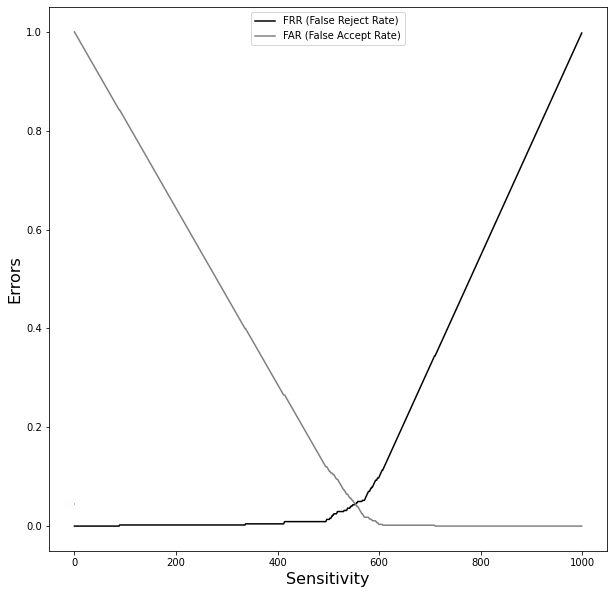

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(stats.fnmr, color='k')
plt.plot(stats.fmr, color='gray')
plt.plot([0,1], [stats.eer, stats.eer], color='red', linestyle='--', alpha=0.5)
plt.xlabel('Sensitivity', fontsize=16)
plt.ylabel('Errors', fontsize=16)
plt.legend(['FRR (False Reject Rate)', 'FAR (False Accept Rate)'])

### Dataset novo dataset (Test 2)

In [ ]:
y_true = list()
y_pred = list()
y_pred_proba = list()
test_model.eval()

with torch.no_grad():
  for batch in test_dataloader:
    inputs, y = batch
    softs = test_model(inputs.cuda())
    softs_mean = torch.mean(softs, dim=0)
    # print(softs_mean)
    pred = pred_emsemble(softs)    
    
    y_true.append(y.cpu().numpy())
    y_pred.append(pred.cpu().numpy())
    y_pred_proba.append(softs_mean.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_pred_proba = np.concatenate(y_pred_proba)

In [ ]:
# given the average predict probability we compute the the class using the threshold=0.5 
y_proba_covid = y_pred_proba[:,1] # probability of covid-19
y_pred_class = np.zeros(len(y_proba_covid))
y_pred_class[y_proba_covid >= 0.5] = 1
y_pred_class[y_proba_covid < 0.5] = 0

In [ ]:
# f1 score (hard-majority vote)
print('f1 - hard-majority vote:', metrics.f1_score(y_true, y_pred, average='weighted'))

# f1 score
print('f1 - soft-majority vote:', metrics.f1_score(y_true, y_pred_class, average='weighted'))

# accuracy
print('acc:', metrics.accuracy_score(y_true, y_pred))

# balanced accuracy
print('balanced acc:', metrics.balanced_accuracy_score(y_true, y_pred))

f1 - hard-majority vote: 0.9564246067029436
f1 - soft-majority vote: 0.9595944695913862
acc: 0.956
balanced acc: 0.8769085699778769


In [ ]:
print('classification report:', metrics.classification_report(y_true, y_pred_class))

classification report:               precision    recall  f1-score   support

           0       0.98      0.98      0.98       909
           1       0.79      0.76      0.78        91

    accuracy                           0.96      1000
   macro avg       0.88      0.87      0.88      1000
weighted avg       0.96      0.96      0.96      1000



Intessante é que o F1 ficou maior que a ACC o que possível

https://stats.stackexchange.com/questions/365310/can-f1-score-be-higher-than-accuracy

In [ ]:
gen_scores = y_proba_covid[y_true == 1]
imp_scores = y_proba_covid[y_true == 0]

# stats = get_eer_stats(y_true, y_proba_covid, hformat=False, ds_scores=True)
stats = get_eer_stats(gen_scores, imp_scores)

In [ ]:
print(f'EER: {stats.eer: .4f}')

EER:  0.0764


In [ ]:
print(f'EER th: {stats.eer_th: .4f}')

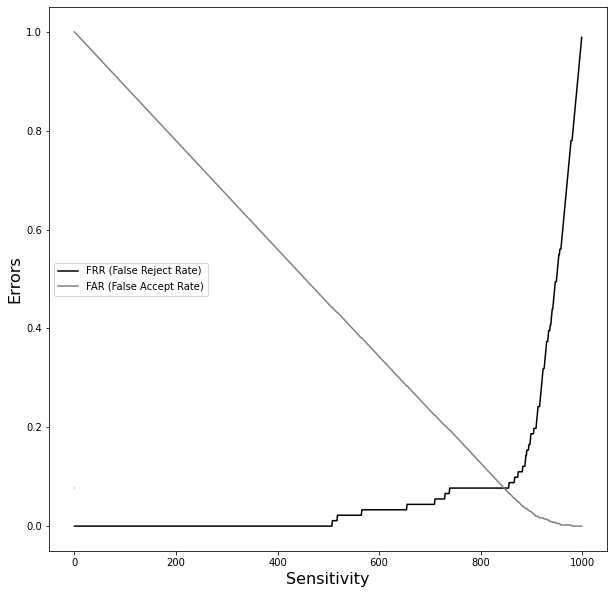

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(stats.fnmr, color='k')
plt.plot(stats.fmr, color='gray')
plt.plot([0,1], [stats.eer, stats.eer], color='red', linestyle='--', alpha=0.5)
plt.xlabel('Sensitivity', fontsize=16)
plt.ylabel('Errors', fontsize=16)
plt.legend(['FRR (False Reject Rate)', 'FAR (False Accept Rate)'])

# Observações Finais



1.   Foco do trabalho foi em tentar obter um modelo robusto (não modelo com maior ACC) que não ficasse viciado no teste, por isso o uso do ensemble.
2.   O ensemble é formado por várias EfficientNet B0, B1, B2, B3, B4
3.   Objetivo principal é aumentar a robustez na predição


